In [1]:
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
plt.style.use('seaborn-white')

x_min = -20
x_max = 20

def griewank(x, gamma=4000):
    n = len(x)
    indices = np.array(range(1, n+1))
    sum_term = np.sum(x*x/gamma)
    prod_term = np.prod(np.cos(x/np.sqrt(indices)))
    return 1 + sum_term - prod_term


def plot_griewank():
    n = 100
    x = np.linspace(x_min, x_max, n)
    y = np.linspace(x_min, x_max, n)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            x = np.array([X[i][j], Y[i][j]])
            Z[i][j] = griewank(x)

    plt.contour(X, Y, Z, cmap='RdGy')
    plt.colorbar()


def grad_griewank(x, gamma=4000):
    n = len(x)
    indices = np.array(range(1, n+1))
    grad = [2*x[i]/gamma + np.prod(np.cos(x/np.sqrt(indices))) * (1/np.cos(x[i] / np.sqrt(i+1))) * np.sin(x[i] / np.sqrt(i+1)) * (1.0 / np.sqrt(i+1)) for i in range(n)]
    return np.array(grad)


def hessian_griewank(x, gamma=4000):
    hessian = np.zeros([2, 2])
    hessian[0][0] = 2.0/gamma + np.cos(x[1]/np.sqrt(2))*np.cos(x[0])
    hessian[0][1] = hessian[1][0] = (-1/np.sqrt(2))*np.sin(x[0])*np.sin(x[1]/np.sqrt(2))
    hessian[1][1] = (2.0/gamma) + 0.5*np.cos(x[0])*np.cos(x[1]/np.sqrt(2))
    return hessian


def grad_is_approx_zero(grad, epsilon=1e-5):
    for grad_val in grad:
        if abs(grad_val) > epsilon:
            return False
    return True


def steepest_descent_griewank(x0, alpha=0.01, epsilon=1e-5, n_iter=10000, debug=False, gamma=4000, use_ebls=True):
    x_vals = []
    obj_vals = []
    grad_vals = []

    n = len(x0)
    x_curr = x0
    for i in range(n_iter):
        if debug:
            print("------------------------")
            print("Iteration: ", i)
            print(x_curr, griewank(x_curr, gamma))
            print("------------------------")

        grad = grad_griewank(x_curr, gamma)

        x_vals.append(x_curr)
        obj_vals.append(griewank(x_curr, gamma))
        grad_vals.append(grad)

        if grad_is_approx_zero(grad, epsilon):
            if debug:
                print("Solution found!", x_curr, griewank(x_curr, gamma), grad)
            break
        if use_ebls:
        	alpha = ebls(x_curr)
        x_next = x_curr - alpha*grad
        x_curr = x_next
    results_df = pd.DataFrame({'x': x_vals, 'obj': obj_vals, 'grad': grad_vals})
    return x_curr, griewank(x_curr, gamma), results_df


def heavy_ball_griewank(x0, alpha=0.01, beta=0.9, epsilon=1e-5, n_iter=1000, debug=False, gamma=4000, use_ebls=True):
    x_vals = []
    obj_vals = []
    grad_vals = []

    n = len(x0)
    x_curr = x0
    x_prev = x0
    for i in range(n_iter):
    	if debug:
	        print("------------------------")
	        print("Iteration: ", i)
	        print(x_curr, griewank(x_curr, gamma))
	        print("------------------------")

        grad = grad_griewank(x_curr, gamma)

        x_vals.append(x_curr)
        obj_vals.append(griewank(x_curr, gamma))
        grad_vals.append(grad)

        if grad_is_approx_zero(grad, epsilon):
            if debug:
                print("Solution found!", x_curr, griewank(x_curr, gamma))
            break
        if use_ebls:
            alpha = ebls(x_curr)
        x_next = x_curr - alpha*grad + beta*(x_curr - x_prev)
        if debug:
            print("Momentum!", x_curr-x_prev)
        x_prev = x_curr
        x_curr = x_next
    results_df = pd.DataFrame({'x': x_vals, 'obj': obj_vals, 'grad': grad_vals})
    return x_curr, griewank(x_curr, gamma), results_df


def ebls(x_0, c1=0.1, c2=0.3, epsilon=1e-5, n_iter=1000, debug=False, gamma=4000):
    L = 0.0
    U = 1e100 # infinity
    alpha = 1
    x_curr = x_0
    n_iter = 0

    while True:
        n_iter += 1
        grad_curr = grad_griewank(x_curr, gamma)
        d = -1 * grad_curr
        grad_next = grad_griewank(x_curr + alpha*d, gamma)
        f_next = griewank(x_curr + alpha*d, gamma)
        f_curr = griewank(x_curr)
        if f_next > (f_curr + c1*alpha*np.matmul(grad_curr.T, d)):
            U = alpha
            alpha = (U + L)/2.0
        elif np.matmul(grad_next.T, d) < c2*(np.matmul(grad_curr.T, d)):
            L = alpha
            if U >= 1e100:
                alpha = 2*L
            else:
                alpha = (L + U)/2.0
        else:
            return alpha


def run_griewank_test(algo='steepest_descent', gamma=4000, n_iter=1000, alpha=0.01, beta=0.9, use_ebls=True):
    results = {'x_opt': [], 'iterations': [], 'f_opt': [], 'x_0': []}
    print "Running test.", datetime.datetime.now()
    for i in range(n_iter):
        # print("Random Restart: {}".format(i))
        x_0 = np.random.uniform(low=x_min, high=x_max, size=2)
        if algo == 'steepest_descent':
        	x_opt, f_opt, results_df = steepest_descent_griewank(x_0, alpha=alpha, gamma=gamma, use_ebls=use_ebls)
        elif algo == 'heavy_ball':
        	x_opt, f_opt, results_df = heavy_ball_griewank(x_0, alpha=alpha, beta=beta, gamma=gamma, use_ebls=use_ebls)
        else:
        	print "No such algorithm bro. The dude abides."
        	exit()
        results['x_opt'].append(x_opt)
        results['iterations'].append(results_df.shape[0])
        results['f_opt'].append(f_opt)
        results['x_0'].append(x_0)
    results_df = pd.DataFrame(results)
    results_df['dist_to_origin'] = results_df.apply(lambda row: np.linalg.norm(row['x_opt']), axis=1)
    print "Test complete."
    return results_df


mean_f_opt = []
mean_dist_to_origin = []
experiment = ['steepest_descent_without_ebls', 'steepest_descent_with_ebls', 'heavy_ball_without_ebls', 'heavy_ball_with_ebls']
n_iter = [1000, 1000, 1000, 1000]
gamma = [500, 500, 500, 500]
alpha = [1, 1, 1, 1]
beta = [0.99, 0.99, 0.99, 0.99]


def save_figure(ax, filename):
    fig = ax.get_figure()
    fig.savefig(filename)
    fig.clear()

def save_results(df, f_opt_df, dist_to_origin_df, filename, hist=True):
    df.to_csv(filename + '.csv')
    mean_f_opt.append(df.f_opt.mean())
    mean_dist_to_origin.append(df.dist_to_origin.mean())
    if hist:
        f_opt_df[filename + '_f_opt'] = df['f_opt']
        dist_to_origin_df[filename + '_d'] = df['dist_to_origin']

        ax = df.dist_to_origin.hist()
        fig = ax.get_figure()
        fig.savefig(filename + ".pdf")
        fig.clear()

def plot_aggregates(f_opt_df, dist_to_origin_df):
    filenames = ['f_opt_aggregated.pdf', 'dist_to_origin_aggregated.pdf']
    for i, df in enumerate([f_opt_df, dist_to_origin_df]):
        ax = df.plot.hist(alpha=0.5)
        save_figure(ax, 'hist_' + filenames[i])
        ax = df.plot.box()
        save_figure(ax, 'box_' + filenames[i])


# f_opt_df = pd.DataFrame()
# dist_to_origin_df = pd.DataFrame()
# df = run_griewank_test('steepest_descent', gamma=500, n_iter=10000, alpha=1, beta=0.99, use_ebls=False)
# save_results(df, f_opt_df, dist_to_origin_df, 'sdesc')
# df = run_griewank_test('steepest_descent', gamma=500, n_iter=10000, alpha=1, beta=0.99, use_ebls=True)
# save_results(df, f_opt_df, dist_to_origin_df, 'sdesc_ebls')
# df = run_griewank_test('heavy_ball', gamma=500, n_iter=10000, alpha=1, beta=0.99, use_ebls=False)
# save_results(df, f_opt_df, dist_to_origin_df, 'hball')
# df = run_griewank_test('heavy_ball', gamma=500, n_iter=10000, alpha=1, beta=0.99, use_ebls=True)
# save_results(df, f_opt_df, dist_to_origin_df, 'hball_ebls', False)

# df = pd.DataFrame({'experiment': experiment, 'mean_f_opt': mean_f_opt, 'mean_dist_to_origin': mean_dist_to_origin,
#                     'max_iter': n_iter, 'gamma': gamma, 'alpha': alpha, 'beta': beta})
# df.to_csv("aggregated_results.csv")
# plot_aggregates(f_opt_df, dist_to_origin_df)


# print df.head()

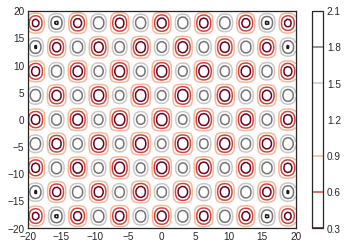

In [2]:
plot_griewank()

Running test. 2019-10-06 15:29:12.926487
Test complete.
              f_opt   iterations  dist_to_origin
count  1.000000e+02   100.000000      100.000000
mean   5.579456e-01  2252.550000       15.751157
std    3.376172e-01   320.351523        5.436505
min    9.850065e-11  1020.000000        0.000020
25%    2.353020e-01  2071.500000       10.810729
50%    5.294276e-01  2282.500000       16.215982
75%    8.439926e-01  2456.250000       20.484311
max    1.334402e+00  3033.000000       25.754142


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feeb11b0ed0>,
      dtype=object)

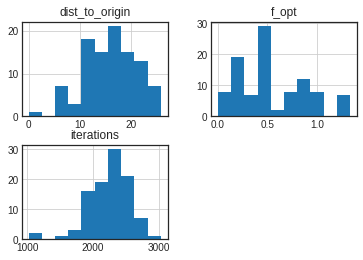

In [3]:
steepest_descent_results_df = run_griewank_test('steepest_descent', gamma=500, n_iter=100, alpha=0.01, beta=0.99, use_ebls=False)
print steepest_descent_results_df.describe()
steepest_descent_results_df.hist()

In [4]:
def hessian_griewank(x, gamma=4000):
    hessian = np.zeros([2, 2])
    hessian[0][0] = 2.0/gamma + np.cos(x[1]/np.sqrt(2))*np.cos(x[0])
    hessian[0][1] = hessian[1][0] = (-1/np.sqrt(2))*np.sin(x[0])*np.sin(x[1]/np.sqrt(2))
    hessian[1][1] = (2.0/gamma) + 0.5*np.cos(x[0])*np.cos(x[1]/np.sqrt(2))
    return hessian

In [5]:
x = np.random.uniform(x_min, x_max, size=2)
print x
hess = hessian_griewank(x)
print hess

[ 9.26707148 19.56964158]
[[-0.2907307  -0.10611521]
 [-0.10611521 -0.14511535]]


In [6]:
w,v = np.linalg.eig(hess)

In [7]:
w

array([-0.34661411, -0.08923194])

In [8]:
print w.min(), w.max()

-0.3466141144564475 -0.08923193881150918


In [9]:
def get_approx_L():
    L = -1
    for i in range(10000):
        x = np.random.uniform(low=x_min, high=x_max, size=2)
        hess = hessian_griewank(x)
        max_eig = np.max(np.linalg.eig(hess)[0])
        # print max_eig
        if max_eig > L:
            L = max_eig
    return L

In [10]:
get_approx_L()

1.0000389834918118